In [ ]:
pip install nsepy

  Preparing metadata (setup.py) ... done
  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36057 sha256=bc141cf6c7f1d71055874daa4c818548957111fa4bb07856668674465f3146d4
  Stored in directory: /root/.cache/pip/wheels/4c/87/cb/acaf83f625e5fc73e1fe6e2a8e97680c74cd72391850ef5a86
Successfully built nsepy


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
from statistics import mean
import nsepy
import matplotlib.pyplot as plt

In [ ]:
# Download the S&P 500 index data
sp500 = yf.download("^GSPC", start="2014-01-01", end="2024-01-01")

# Select 5 tickers from the S&P 500
tickers = ["AAPL", "MSFT", "AMZN", "GOOG"]

# Download the historical data of the selected tickers
data = yf.download(tickers, start="2014-01-01", end="2024-01-01")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  4 of 4 completed


In [ ]:
# Define a function to calculate the trailing stop loss
def trailing_stop_loss(data, ticker, pct=0.1):
    # Calculate the daily returns
    returns = data["Adj Close",ticker].pct_change()

    # Initialize the peak price and the stop loss price
    peak = data["Adj Close",ticker][0]
    stop_loss = peak * (1 - pct)

    # Initialize the exit signal
    exit_signal = pd.Series(0, index=data.index)

    # Loop through the data and update the peak, stop loss, and exit signal
    for i in range(1, len(data)):
        price = data["Adj Close",ticker][i]
        if price > peak:
            peak = price
            stop_loss = peak * (1 - pct)
        elif price < stop_loss:
            exit_signal[i] = 1
            peak = price
            stop_loss = peak * (1 - pct)

    # Return the exit signal
    return exit_signal
# Apply the function to each ticker and store the results in a dictionary
exit_signals = {}
for ticker in tickers:
    exit_signals[ticker] = trailing_stop_loss(data, ticker)


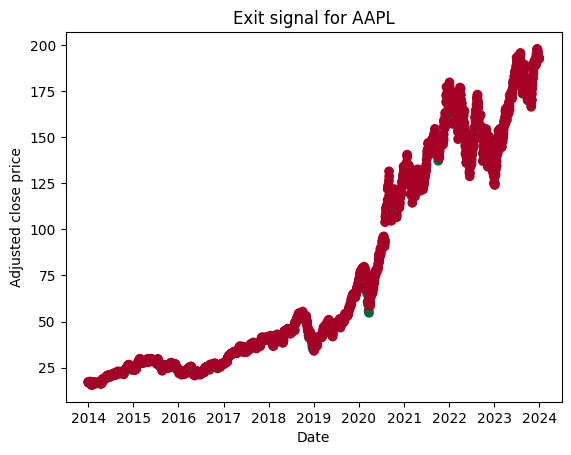

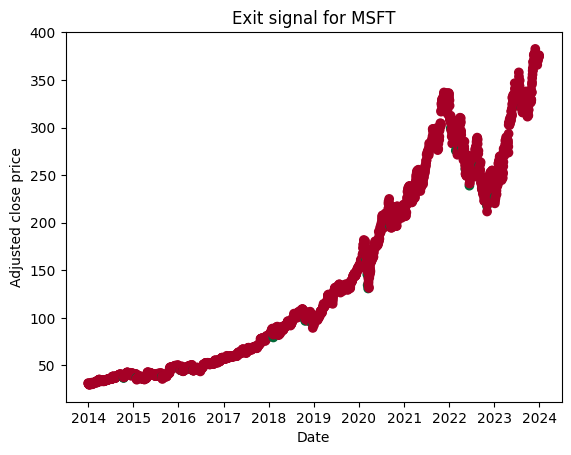

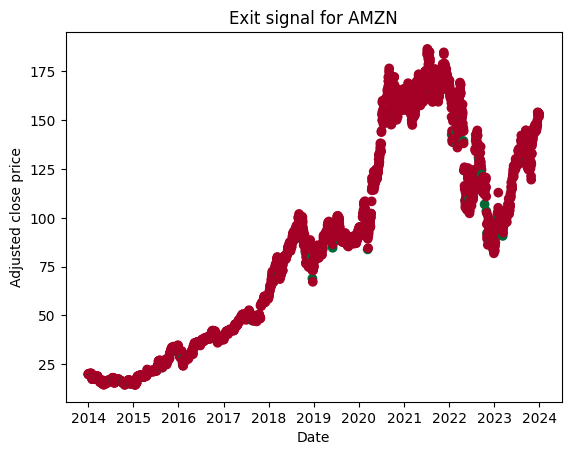

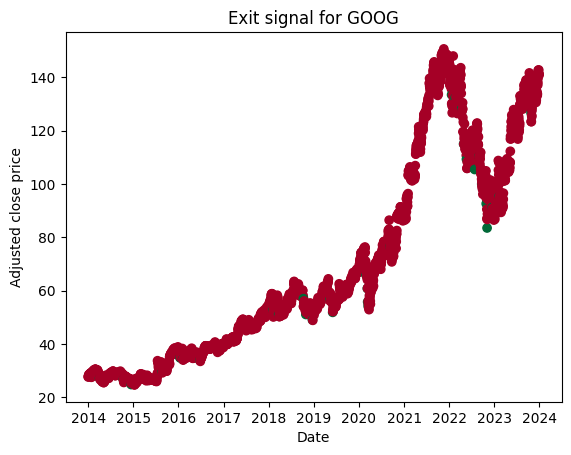

In [ ]:
import matplotlib.pyplot as plt
# Define a portfolio weight for each ticker
weights = [0.4, 0.2, 0.3,0.1]

# Define a trailing stop loss percentage
pct = 0.1

# Loop through the tickers
for ticker in tickers:
    # Calculate the exit signal for the ticker using the vectorized function
    exit_signal = trailing_stop_loss(data, ticker, pct)

    # Plot the exit signal as a scatter plot
    plt.scatter(data.index, data["Adj Close", ticker], c=exit_signal, cmap="RdYlGn")

    # Set the title, xlabel, and ylabel
    plt.title(f"Exit signal for {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Adjusted close price")

    # Show the plot
    plt.show()

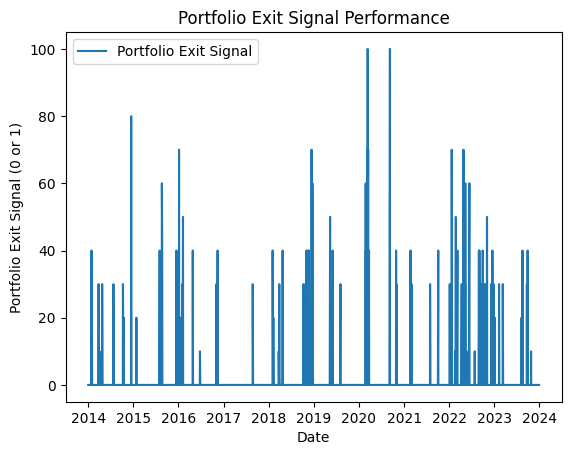

In [ ]:
# Calculate the portfolio weights
weights = [0.4, 0.2, 0.3,0.1]

# Assume you have 100 shares of each ticker
amounts = [100, 100, 100, 100]

# Calculate the portfolio exit signal
portfolio_exit_signal = pd.DataFrame(exit_signals).mul(amounts).mul(weights).sum(axis=1)

# Plot the portfolio exit signal
plt.plot(portfolio_exit_signal.index, portfolio_exit_signal, label="Portfolio Exit Signal")

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Portfolio Exit Signal (0 or 1)")
plt.title("Portfolio Exit Signal Performance")
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Define a function to calculate the moving average crossover
def moving_average_crossover(data, ticker, short=50, long=200):
    # Calculate the short-term and long-term moving averages
    data["SMA",ticker] = data["Adj Close",ticker].rolling(short).mean()
    data["LMA",ticker] = data["Adj Close",ticker].rolling(long).mean()

    # Initialize the entry signal
    entry_signal = pd.Series(0, index=data.index)

    # Loop through the data and update the entry signal
    for i in range(1, len(data)):
        # Buy signal: when the short-term moving average crosses above the long-term moving average
        if data["SMA",ticker][i] > data["LMA",ticker][i] and data["SMA",ticker][i-1] < data["LMA",ticker][i-1]:
            entry_signal[i] = 1
        # Sell signal: when the short-term moving average crosses below the long-term moving average
        elif data["SMA",ticker][i] < data["LMA",ticker][i] and data["SMA",ticker][i-1] > data["LMA",ticker][i-1]:
            entry_signal[i] = -1

    # Return the entry signal
    return entry_signal

# Define a function to calculate the Bollinger Bands breakout
def bollinger_bands_breakout(data, ticker, window=20, std=2):
    # Calculate the middle band (simple moving average)
    data["MB",ticker] = data["Adj Close",ticker].rolling(window).mean()

    # Calculate the upper band and lower band (standard deviation)
    data["UB",ticker] = data["MB",ticker] + std * data["Adj Close",ticker].rolling(window).std()
    data["LB",ticker] = data["MB",ticker] - std * data["Adj Close",ticker].rolling(window).std()

    # Initialize the entry signal
    entry_signal = pd.Series(0, index=data.index)

    # Loop through the data and update the entry signal
    for i in range(1, len(data)):
        # Buy signal: when the price breaks above the upper band
        if data["Adj Close",ticker][i] > data["UB",ticker][i] and data["Adj Close",ticker][i-1] < data["UB",ticker][i-1]:
            entry_signal[i] = 1
        # Sell signal: when the price breaks below the lower band
        elif data["Adj Close",ticker][i] < data["LB",ticker][i] and data["Adj Close",ticker][i-1] > data["LB",ticker][i-1]:
            entry_signal[i] = -1

    # Return the entry signal
    return entry_signal

# Define a function to calculate the RSI divergence
def rsi_divergence(data, ticker, window=14):
    # Calculate the daily change
    delta = data["Adj Close",ticker].diff()

    # Calculate the positive and negative gains
    gain = delta.clip(lower=0)
    loss = delta.clip(upper=0).abs()

    # Calculate the average positive and negative gains
    avg_gain = gain.ewm(com=window-1, min_periods=window).mean()
    avg_loss = loss.ewm(com=window-1, min_periods=window).mean()

    # Calculate the relative strength and the RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data["RSI",ticker] = rsi

    # Initialize the entry signal
    entry_signal = pd.Series(0, index=data.index)

    # Loop through the data and update the entry signal
    for i in range(window, len(data)):
        # Buy signal: when the price makes a lower low but the RSI makes a higher low
        if data["Adj Close",ticker][i] < data["Adj Close",ticker][i-window] and data["RSI",ticker][i] > data["RSI",ticker][i-window]:
            entry_signal[i] = 1
        # Sell signal: when the price makes a higher high but the RSI makes a lower high
        elif data["Adj Close",ticker][i] > data["Adj Close",ticker][i-window] and data["RSI",ticker][i] < data["RSI",ticker][i-window]:
            entry_signal[i] = -1

    # Return the entry signal
    return entry_signal

# Define a function to calculate the stochastic oscillator
def stochastic_oscillator(data, ticker, k=14, d=3):
    # Calculate the lowest low and the highest high in the last k periods
    low = data["Low",ticker].rolling(k).min()
    high = data["High",ticker].rolling(k).max()

    # Calculate the %K and the %D
    data["%K",ticker] = (data["Adj Close",ticker] - low) / (high - low) * 100
    data["%D",ticker] = data["%K",ticker].rolling(d).mean()

    # Initialize the entry signal
    entry_signal = pd.Series(0, index=data.index)

    # Loop through the data and update the entry signal
    for i in range(1, len(data)):
        # Buy signal: when the %K crosses above the %D from below 20
        if data["%K",ticker][i] > data["%D",ticker][i] and data["%K",ticker][i-1] < data["%D",ticker][i-1] and data["%K",ticker][i] < 20:
            entry_signal[i] = 1
        # Sell signal: when the %K crosses below the %D from above 80
        elif data["%K",ticker][i] < data["%D",ticker][i] and data["%K",ticker][i-1] > data["%D",ticker][i-1] and data["%K",ticker][i] > 80:
            entry_signal[i] = -1

    # Return the entry signal
    return entry_signal


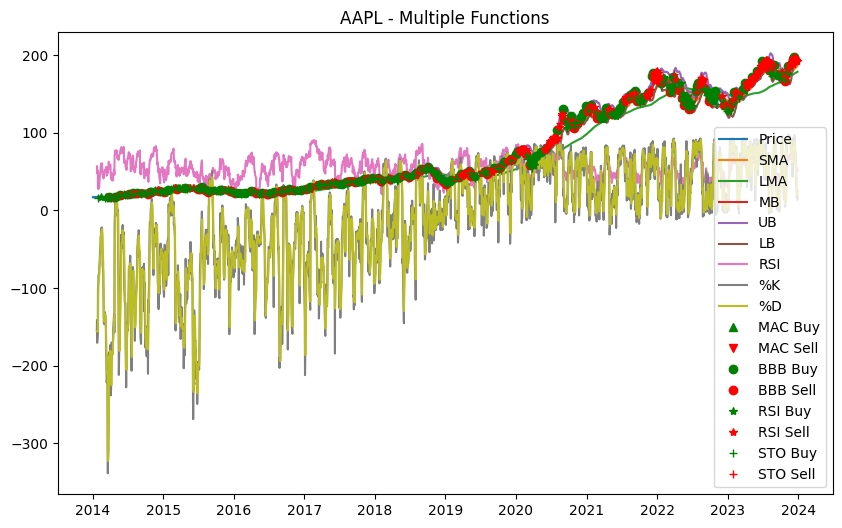

In [ ]:
#plot the moving average crossover, the Bollinger Bands breakout, the RSI divergence, and the stochastic oscillator for a single ticker in one graph:
# Choose a ticker
ticker = "AAPL"

# Calculate the functions
mac = moving_average_crossover(data, ticker)
bbb = bollinger_bands_breakout(data, ticker)
rsi = rsi_divergence(data, ticker)
sto = stochastic_oscillator(data, ticker)

# Plot the functions
plt.figure(figsize=(10,6))
plt.plot(data["Adj Close",ticker], label="Price")
plt.plot(data["SMA",ticker], label="SMA")
plt.plot(data["LMA",ticker], label="LMA")
plt.plot(data["MB",ticker], label="MB")
plt.plot(data["UB",ticker], label="UB")
plt.plot(data["LB",ticker], label="LB")
plt.plot(data["RSI",ticker], label="RSI")
plt.plot(data["%K",ticker], label="%K")
plt.plot(data["%D",ticker], label="%D")
plt.plot(data["Adj Close",ticker][mac == 1], "^", color="green", label="MAC Buy")
plt.plot(data["Adj Close",ticker][mac == -1], "v", color="red", label="MAC Sell")
plt.plot(data["Adj Close",ticker][bbb == 1], "o", color="green", label="BBB Buy")
plt.plot(data["Adj Close",ticker][bbb == -1], "o", color="red", label="BBB Sell")
plt.plot(data["Adj Close",ticker][rsi == 1], "*", color="green", label="RSI Buy")
plt.plot(data["Adj Close",ticker][rsi == -1], "*", color="red", label="RSI Sell")
plt.plot(data["Adj Close",ticker][sto == 1], "+", color="green", label="STO Buy")
plt.plot(data["Adj Close",ticker][sto == -1], "+", color="red", label="STO Sell")
plt.title(ticker + " - Multiple Functions")
plt.legend()
plt.show()

In [ ]:
# Define a function to create a trading system
def trading_system(data, ticker, entry_signal, exit_signal, risk_per_trade):
    # Call the entry signal function and the exit signal function
    data["Entry"] = entry_signal(data, ticker)
    data["Exit"] = exit_signal(data, ticker)

    # Vectorize the position logic using numpy.where
    # If the entry signal is 1 and the exit signal is 0, the position is 1 (long)
    # Else, if the entry signal is -1 and the exit signal is 0, the position is -1 (short)
    # Else, the position is 0 (no position)
    data["Position"] = np.where((data["Entry"] == 1) & (data["Exit"] == 0), 1,
                       np.where((data["Entry"] == -1) & (data["Exit"] == 0), -1, 0))

    # Calculate the returns as the percentage change of the prices
    data["Returns"] = data["Adj Close",ticker].pct_change()

    # Calculate the strategy returns as the product of the positions and the returns
    data["Strategy Returns"] = data["Position"] * data["Returns"]

    # Calculate the account balance as the cumulative product of the strategy returns
    data["Account Balance"] = (data["Strategy Returns"] + 1).cumprod()

    # Calculate the trade size as the product of the account balance and the risk per trade
    data["Trade Size"] = data["Account Balance"] * risk_per_trade

    # Return the DataFrame with the positions, returns, strategy returns, account balance, and trade size columns
    return data[["Entry", "Exit", "Position", "Returns", "Strategy Returns", "Account Balance", "Trade Size"]]

In [ ]:
# Define a function to backtest a trading system
def backtest(data, ticker, entry_signal, exit_signal, risk_per_trade):
    # Call the trading system function
    df = trading_system(data, ticker, entry_signal, exit_signal, risk_per_trade)

    # Calculate the annualized returns as the product of the mean of the strategy returns and 252
    annualized_returns = df["Strategy Returns"].mean() * 252

    # Calculate the annualized volatility as the product of the standard deviation of the strategy returns and the square root of 252
    annualized_volatility = df["Strategy Returns"].std() * np.sqrt(252)

    # Calculate the maximum drawdown as the maximum drop from the peak to the trough of the account balance
    max_drawdown = (df["Account Balance"].cummax() - df["Account Balance"]).max()

    # Calculate the Sharpe ratio as the ratio of the annualized returns and the annualized volatility
    sharpe_ratio = annualized_returns / annualized_volatility

    # Return a dictionary with the four metrics as the keys and the values
    return {"Returns": annualized_returns, "Volatility": annualized_volatility, "Drawdown": max_drawdown, "Sharpe Ratio": sharpe_ratio}


In [ ]:
# Define a list of entry signals
entry_signals = [moving_average_crossover, bollinger_bands_breakout, rsi_divergence, stochastic_oscillator]

# Define a dictionary to store the results
results = {}

# Loop through the entry signals
for entry_signal in entry_signals:
    # Initialize a list to store the metrics
    metrics = []
    # Loop through the tickers
    for ticker in tickers:
        # Call the backtest function with the trailing stop loss as the exit signal and 1% as the risk per trade
        result = backtest(data, ticker, entry_signal, trailing_stop_loss, 0.01)
        # Append the result to the metrics list
        metrics.append(result)
    # Convert the metrics list to a DataFrame
    metrics = pd.DataFrame(metrics, index=tickers)
    # Calculate the portfolio metrics by multiplying the individual metrics by the portfolio weights and summing them up
    portfolio_metrics = metrics.mul(weights, axis=0).sum()
    # Store the portfolio metrics in the results dictionary with the entry signal name as the key
    results[entry_signal.__name__] = portfolio_metrics
# Convert the results dictionary to a DataFrame
results = pd.DataFrame(results)
# Print the results
print(results)

              moving_average_crossover  bollinger_bands_breakout  \
Returns                       0.006657                  0.361402   
Volatility                    0.023874                  0.122080   
Drawdown                      0.038108                  0.000000   
Sharpe Ratio                  0.218078                  2.974041   

              rsi_divergence  stochastic_oscillator  
Returns             0.109331               0.172482  
Volatility          0.133319               0.081652  
Drawdown            0.347835               0.399630  
Sharpe Ratio        0.806353               1.845170  
